# M1M3 vibration coming from the topple block

* This notebook is originally written by Dominique Boutigny associated to [SITCOM-784](https://rubinobs.atlassian.net/browse/SITCOM-784)
* It contains the analysis associated to the Technical Note: SITCOMTN-131
* The original notebook was editted by HyeYun Park for [SITCOM-1390](https://rubinobs.atlassian.net/browse/SITCOM-1390)
* to provide additional plots to the SITCOMTN-081, associated with SITCOM-918

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

%load_ext lab_black

In [2]:
import os.path

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import h5py
import numpy as np

from astropy.time import Time
from astropy.time import TimeDelta
from astropy import units as u
import matplotlib.dates as mdates
from matplotlib.ticker import FormatStrFormatter
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from matplotlib import ticker
from scipy.signal import stft
from scipy.signal import find_peaks_cwt
from scipy import signal
from scipy.fft import fft, rfft, fftfreq, rfftfreq


from lsst_efd_client import EfdClient
from lsst.summit.utils.tmaUtils import TMAEventMaker, TMAState, TMAEvent
from lsst.summit.utils.efdUtils import getEfdData, makeEfdClient, getSubTopics
from lsst.ts.xml.enums import MTM1M3, MTMount

In [3]:
# Utility functions
key_m1m3_dict = {
    "1 X": "m1m3_x_1",
    "1 Y": "m1m3_y_1",
    "1 Z": "m1m3_z_1",
    "2 X": "m1m3_x_2",
    "2 Y": "m1m3_z_2",  # note these two have been
    "2 Z": "m1m3_y_2",  # switched pending SUMMIT-7911
    "3 X": "m1m3_x_3",
    "3 Y": "m1m3_y_3",
    "3 Z": "m1m3_z_3",
}
key_m2_dict = {
    "1 X": "m2_x_1",
    "1 Y": "m2_y_1",
    "1 Z": "m2_z_1",
    "2 X": "m2_x_2",
    "2 Y": "m2_z_2",
    "2 Z": "m2_y_2",
    "3 X": "m2_x_3",
    "3 Y": "m2_z_3",
    "3 Z": "m2_y_3",
    "4 X": "m2_x_4",
    "4 Y": "m2_y_4",
    "4 Z": "m2_z_4",
    "5 X": "m2_x_5",
    "5 Y": "m2_z_5",
    "5 Z": "m2_y_5",
    "6 X": "m2_x_6",
    "6 Y": "m2_z_6",
    "6 Z": "m2_y_6",
}


def vms_data_to_pandas(filename, vms_type, begin_time=None, end_time=None):
    """
    Converts VMS data in the given HDF5 file to a Pandas DataFrame.

    Args:
    filename: Path to the HDF5 file containing the VMS data.
    vms_type: The type of VMS data in the file. Must be "m1m3", "m2", or
      "rotator".
    begin_time: The start time of the data to include in the DataFrame. If None,
      all data will be included.
    end_time: The end time of the data to include in the DataFrame. If None, all
      data will be included.

    Returns:
    A Pandas DataFrame containing the VMS data.
    """
    if vms_type == "m1m3":
        key_dict = key_m1m3_dict
    elif vms_type == "m2":
        key_dict = key_m2_dict
    elif vms_type == "rotator":
        raise NotImplementedError
    else:
        raise ValueError("vms_type must be m1m3,m2, or rotator")

    f = h5py.File(filename, "r")
    times = f["timestamp"][::1]
    dkeys = "XYZ"

    data_dict = {}
    if (begin_time is not None) & (end_time is not None):
        sel = (times > begin_time) & (times < end_time)
    else:
        sel = np.ones(times.size).astype(bool)
    data_dict["times"] = times[sel]
    for key in key_dict.keys():
        # multiply values stored in hdf5 files by 2 in order to convert the acceleration values to mg
        data_dict[key_dict[key]] = f[key][::1][sel] * 2.0
    data_frame = pd.DataFrame(data_dict)
    for j in np.arange(int(len(key_dict) / 3)) + 1:
        data_frame[f"total_{j}"] = np.linalg.norm(
            data_frame[[f"{vms_type}_{i}_{j}" for i in ["x", "y", "z"]]].values, axis=1
        )

    return data_frame


def get_freq_psd(vals, timestep):
    """
    Calculates the frequency power spectrum of a signal.

    Args:
        vals (np.array): The signal values.
        timestep (float): The time step between samples.

    Returns:
        tuple: The frequencies and power spectral density.
    """

    # Remove the mean from the signal.

    meanval = np.mean(vals)
    signal = vals - meanval

    # Calculate the length of the signal.

    N = len(signal)

    # Calculate the power spectral density.

    psd = np.abs(np.fft.rfft(np.array(signal) * 1)) ** 2

    # Calculate the frequencies.

    frequencies = np.fft.rfftfreq(N, timestep)
    return (frequencies, psd)


def get_psd_and_dsd_for_vms(vals, timestep, min_freq=1, g=False):
    """
    Calculate the PSD and DSD from VMS data, and total displacement from DSD.

    Parameters:
    - vals (array-like): VMs in m/s^2 or milli-g if 'g' is True.
    - timestep (float): Time step between measurements in seconds.
    - min_freq (float, optional): Minimum frequency for calculations.
                                  Default is 1 Hz.
    - g (bool, optional): True if 'vals' are in milli-g units.
                          Default is False.

    Returns:
    - psds_df (DataFrame): DataFrame with frequencies ('freq'), acceleration
                           PSD ('accel_psd'), displacement PSD ('disp_psd'),
                           and cumulative displacement PSD ('int_disp').
    - total_displacement (float): Total displacement from vibration data.

    Note:
    PSD adjusted to m/s^2/Hz. 'vals' converted to m/s^2 if 'g' is True.
    """
    if g:
        vals = 1e-3 * 9.8 * vals

    # freq, accel_psd = signal.periodogram(vals, 1/timestep)
    # print("using scipy")
    freq, accel_psd = get_freq_psd(vals, timestep)

    sel = freq > min_freq
    freq = freq[sel]
    accel_psd = accel_psd[sel]

    accel_psd = accel_psd * np.mean(np.diff(freq))

    disp_psd_sq = accel_psd / ((2 * np.pi * freq) ** 4)

    int_displace_psd = np.sqrt(np.cumsum(disp_psd_sq))
    total_displacement = np.sqrt(np.sum(disp_psd_sq))

    psds_df = pd.DataFrame(
        {
            "freq": freq,
            "accel_psd": accel_psd,
            "disp_psd": np.sqrt(disp_psd_sq),
            "int_disp": int_displace_psd,
        }
    )

    return psds_df, total_displacement

In [4]:
# Create a directory to save plots
plot_dir = "./plots"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

In [5]:
# Acquisition date of VMS data
# (need to download vms data. Dominique has one for 2023.11.29. I am using 3 different dates to compare, but 2023-11-29 is only date we have VMS data. we can download more.)
vms_date = "2023-11-29"

vms_top_dir = "/sdf/scratch/users/b/boutigny/vmsdata"
year, month = vms_date.split("-")[0:2]

# Directory containing VMS data
vms_dir = os.path.join("/scratch/users/b/boutigny/vmsdata", year, month)

# Check if a parquet file exists
# If yes, we read the pandas dataframe directly from it
# If not, we read the hdf file and re-create the pandas dataframe
vms_m1m3_parquet_filename = os.path.join(
    vms_dir, "M1M3-" + vms_date + "T00:00.parquet"
)  # "T00:00.parquet")
if os.path.isfile(vms_m1m3_parquet_filename):
    print(f"Reading VMS data from parquet file:{vms_m1m3_parquet_filename}")
    vms_m1m3_data = pd.read_parquet(vms_m1m3_parquet_filename)
else:
    vms_m1m3_hdf_filename = os.path.join(
        vms_dir, "M1M3-" + vms_date + "T00:00.hdf"
    )  # "T00:00.hdf")
    print(f"Reading VMS data from hdf5 file:{vms_m1m3_hdf_filename}")
    vms_m1m3_data = vms_data_to_pandas(vms_m1m3_hdf_filename, vms_type="m1m3")
    # Remove entries with null timestamps
    vms_m1m3_data = vms_m1m3_data[vms_m1m3_data["times"] > 0]
    # Reformat timestamps
    vms_m1m3_data["times"] = Time(vms_m1m3_data["times"], format="unix").datetime

Reading VMS data from parquet file:/scratch/users/b/boutigny/vmsdata/2023/11/M1M3-2023-11-29T00:00.parquet


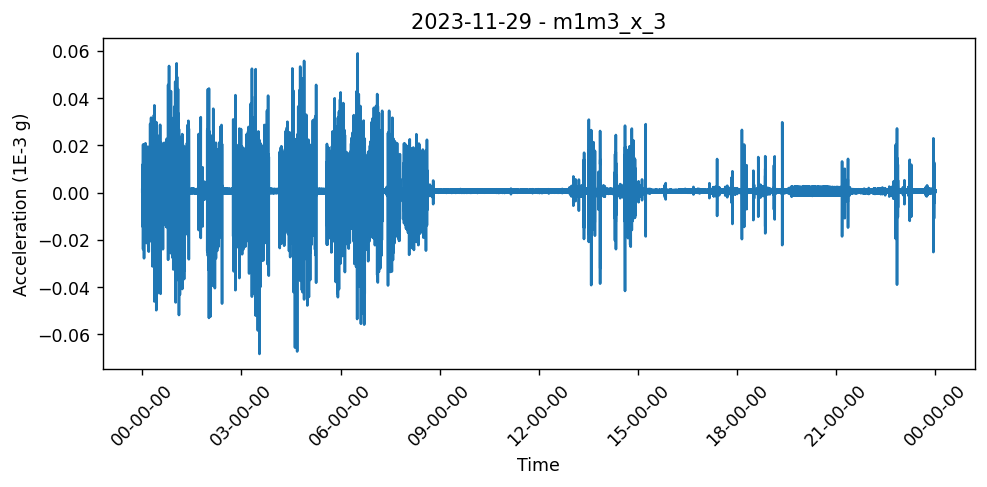

In [6]:
%matplotlib inline
# First look at the raw VMS data - We plot only 1 sensor and 1 axis because the full dataset is very large and requires too much memory
# to be displayed
fig, ax = plt.subplots(1, 1, dpi=125, figsize=(8, 4))
key = "m1m3_x_3"
ax.plot(vms_m1m3_data["times"], vms_m1m3_data[key])
ax.set(ylabel="Acceleration (1E-3 g)", xlabel="Time", title=f"{vms_date} - {key}")
ax.xaxis.set_major_formatter(DateFormatter("%H-%M-%S"))
plt.setp(ax.get_xticklabels(), rotation=45)
fig.tight_layout()
fig.savefig(f"{plot_dir}/VMS-accel-{vms_date}.png")

### Using EFD data

In [7]:
# Retrieve TMA events corresponding to the VMS acquisition date
# As VMS and TMA do not cover the same time window, we need to get the TMA events corresponding to both
# dayObs and the day before dayObs
efd_date = "2023-11-29"  # "2024-01-04"  # "2023-11-29"

dayObs = int(efd_date.replace("-", "", 2))
efd_time = Time(efd_date + "T00:00:00")
delta_t = TimeDelta(1, format="jd")
day_before = int(str(efd_time - delta_t)[0:10].replace("-", "", 2))
eventMaker = TMAEventMaker()
events = eventMaker.getEvents(day_before)
events = events + eventMaker.getEvents(dayObs)

# Get lists of slew events
slews = [e for e in events if e.type == TMAState.SLEWING]
print(f"Found {len(slews)} slews")

Found 971 slews


In [8]:
# Filter the list of slews in order to keep the ones that are fully contained within the day corresponding to the VMS file.
date_min = Time(f"{efd_date} 00:00:00.00").unix
date_end = Time(f"{efd_date} 23:59:59.00").unix
sel_slews = [
    slews[i]
    for i in range(len(slews))
    if (slews[i].begin.unix > date_min and slews[i].end.unix < date_end)
]
print(f"Selected {len(sel_slews)} slews out of {len(slews)} for {dayObs}")

Selected 529 slews out of 971 for 20231129


In [9]:
# Check that all the selected slews fall within dayObs
print(sel_slews[0].begin.datetime64, sel_slews[-1].end.datetime64)

2023-11-29T00:00:40.341081858 2023-11-29T23:58:34.546860933


In [10]:
client = EfdClient("usdf_efd")

In [11]:
# Print slews amplitudes and speed in azimuth and elevation
# This is intended to help selecting large slews that will be studied in details
# The selected slew numbers will be stored in variables slew_azi and slew_ele
# by default they contain the slews with the largest amplitudes
max_delta_azi = -99
max_delta_ele = -99
for i_slew, slew in enumerate(sel_slews):
    df_ele = getEfdData(client, "lsst.sal.MTMount.elevation", event=slew)
    df_azi = getEfdData(client, "lsst.sal.MTMount.azimuth", event=slew)

    t1 = slew.begin.datetime64
    t2 = slew.end.datetime64
    if len(df_ele) > 0:
        slew_delta_ele = df_ele["actualPosition"].max() - df_ele["actualPosition"].min()
        if slew_delta_ele > 30:
            print(
                f"Slew number: {i_slew} - Delta ele: {slew_delta_ele:.1f} degrees - Speed: {abs(df_ele['actualVelocity']).max()}",
                df_ele["actualPosition"].min(),
                df_ele["actualPosition"].max(),
            )
        if slew_delta_ele > max_delta_ele:
            max_delta_ele = slew_delta_ele
            slew_ele = i_slew
    if len(df_azi) > 0:
        slew_delta_azi = df_azi["actualPosition"].max() - df_azi["actualPosition"].min()
        if slew_delta_azi > 30:
            print(
                f"Slew number: {i_slew} - Delta azi: {slew_delta_azi:.1f} degrees - Speed: {abs(df_azi['actualVelocity']).max()}",
                df_azi["actualPosition"].min(),
                df_azi["actualPosition"].max(),
            )
        if slew_delta_azi > max_delta_azi:
            max_delta_azi = slew_delta_azi
            slew_azi = i_slew
print(
    f"Maximum amplitude slew in azimuth: {slew_azi} / {max_delta_azi:.1f} degrees - in elevation: {slew_ele} / {max_delta_ele:.1f} degrees"
)

Slew number: 32 - Delta azi: 59.1 degrees - Speed: 7.70906300987871 -73.9260086046966 -14.7936093184492
Slew number: 65 - Delta azi: 42.8 degrees - Speed: 7.69932784441156 -121.712380351761 -78.9349745864469
Slew number: 98 - Delta azi: 36.6 degrees - Speed: 7.69133390109748 -152.237397544368 -115.679731317429


Slew number: 167 - Delta azi: 98.2 degrees - Speed: 7.69625945096044 -105.032067106602 -6.80250381365309
Slew number: 199 - Delta azi: 104.8 degrees - Speed: 7.70333475327914 -119.780739740759 -15.0252615153645
Slew number: 267 - Delta ele: 32.1 degrees - Speed: 4.00884508466878 33.3723744519259 65.4737894872178
Slew number: 267 - Delta azi: 72.0 degrees - Speed: 7.69652149920153 -121.105884170825 -49.0903649888043
Slew number: 300 - Delta azi: 33.6 degrees - Speed: 7.70303295614497 -93.0203540640581 -59.4432332982293
Slew number: 333 - Delta azi: 47.7 degrees - Speed: 7.69930392145605 -144.742724808988 -97.004836793981
Slew number: 366 - Delta azi: 249.3 degrees - Speed: 7.70705937140531 -145.625858548114 103.658666758508


Slew number: 371 - Delta azi: 34.9 degrees - Speed: 7.7016917991783 102.555273543528 137.47240079946
Slew number: 391 - Delta azi: 311.0 degrees - Speed: 7.67354075244251 -147.541066088446 163.46535861152


Slew number: 394 - Delta azi: 300.9 degrees - Speed: 7.7221326655407 -145.25189411395 155.609772909379
Slew number: 402 - Delta azi: 34.6 degrees - Speed: 7.69741069657611 109.631714362794 144.274481522755
Slew number: 404 - Delta azi: 119.1 degrees - Speed: 7.72464015795462 17.5811264729963 136.684567491364
Slew number: 405 - Delta azi: 60.1 degrees - Speed: 7.72830147233369 -43.6003062816389 16.4763931410321
Slew number: 407 - Delta azi: 36.1 degrees - Speed: 7.69561905224205 -109.839942768847 -73.759229732859
Slew number: 409 - Delta azi: 51.4 degrees - Speed: 7.69497276470122 -104.139597445618 -52.7072244951757
Slew number: 410 - Delta azi: 47.7 degrees - Speed: 7.70033886475759 -100.922110869857 -53.2319882766326
Slew number: 411 - Delta azi: 65.6 degrees - Speed: 7.6900718738441 -100.832626924719 -35.193716774115


Slew number: 416 - Delta azi: 35.5 degrees - Speed: 7.71373424047745 -78.2119121967525 -42.738179917385
Slew number: 417 - Delta azi: 56.4 degrees - Speed: 7.69638458641121 -135.035174241673 -78.6594132413085
Slew number: 418 - Delta azi: 131.2 degrees - Speed: 7.69112889987038 -134.715626052578 -3.5027750077193
Slew number: 420 - Delta azi: 35.7 degrees - Speed: 7.72101859250043 -68.4782424367252 -32.7752762323664
Slew number: 421 - Delta azi: 42.7 degrees - Speed: 7.69834700376367 -111.491842373964 -68.8375928861368
Slew number: 422 - Delta azi: 30.5 degrees - Speed: 7.69811587132831 -111.306556611195 -80.8382297118597
Slew number: 423 - Delta azi: 44.8 degrees - Speed: 7.69808348335832 -125.875036840854 -81.0251406197471


Slew number: 427 - Delta azi: 32.1 degrees - Speed: 7.70485846074528 -146.342149582448 -114.254477527304
Slew number: 428 - Delta azi: 37.3 degrees - Speed: 7.69683212938488 -151.411266265119 -114.087120614427
Slew number: 429 - Delta azi: 75.9 degrees - Speed: 7.69738125293942 -151.148586521977 -75.2452089573209
Slew number: 430 - Delta azi: 47.0 degrees - Speed: 7.69769924405858 -122.667031623609 -75.6494985175986


Slew number: 436 - Delta azi: 228.5 degrees - Speed: 7.00517642787598 -125.97292908202 102.569503956909
Slew number: 440 - Delta azi: 55.7 degrees - Speed: 1.00558617272408 97.2855924069247 152.995610211359
Slew number: 452 - Delta azi: 148.8 degrees - Speed: 7.01238643475133 0.026283161562466 148.827288330655
Slew number: 453 - Delta azi: 90.0 degrees - Speed: 7.00604979932413 1.40379811198068e-07 89.9776509393024


Slew number: 455 - Delta ele: 42.7 degrees - Speed: 4.02016824280472 30.0001489617383 72.6573881638699
Slew number: 455 - Delta azi: 216.2 degrees - Speed: 7.6994680696478 -126.184273182519 89.9999856072476


Slew number: 459 - Delta azi: 116.1 degrees - Speed: 7.00659413824303 -116.190140089196 -0.0441237093565561
Slew number: 461 - Delta ele: 60.0 degrees - Speed: 3.5196608429955 20.0000043991071 80.0000004684585
Slew number: 461 - Delta azi: 100.0 degrees - Speed: 7.0073504712965 -3.68626796470371e-07 99.999284131675
Slew number: 465 - Delta azi: 99.0 degrees - Speed: 7.00618781629807 -8.07918253575968e-07 98.9697168413729
Slew number: 468 - Delta ele: 36.8 degrees - Speed: 3.51584853671596 43.2366949465285 80.0000101532508
Slew number: 468 - Delta azi: 83.9 degrees - Speed: 7.00751719580752 1.03304121492941 84.9561983502356
Slew number: 469 - Delta ele: 63.0 degrees - Speed: 3.50613390198372 17.0213140200099 80.0000003883497
Slew number: 469 - Delta azi: 68.0 degrees - Speed: 7.00101935654889 84.9999999292269 153.000002184969


Slew number: 476 - Delta ele: 54.1 degrees - Speed: 4.02185877972745 16.000108682048 70.0843079675171
Slew number: 476 - Delta azi: 268.5 degrees - Speed: 7.70339106419828 -116.514344781311 151.999959845444


Slew number: 494 - Delta azi: 239.3 degrees - Speed: 7.01252776414894 -136.272275090027 103.015382103779
Slew number: 496 - Delta azi: 103.0 degrees - Speed: 0.100878264590898 0.0 103.015283789317
Slew number: 501 - Delta azi: 52.0 degrees - Speed: 0.908400138297213 100.969103180004 152.995235118315
Slew number: 508 - Delta ele: 53.3 degrees - Speed: 3.5116155804075 5.02090013436336 58.2972443138723
Slew number: 509 - Delta ele: 81.5 degrees - Speed: 3.53134644801157 4.99999907127795 86.4825910765395
Slew number: 509 - Delta azi: 157.2 degrees - Speed: 7.00477893899611 -27.1998393848271 130.00000022312
Slew number: 510 - Delta azi: 100.0 degrees - Speed: 7.00256625081843 -27.2000002033127 72.751317372261
Slew number: 511 - Delta azi: 165.8 degrees - Speed: 7.00521323241509 -92.9804279444283 72.8000003176556
Slew number: 517 - Delta azi: 63.6 degrees - Speed: 7.00555956302071 -90.8342430849136 -27.2330570832996
Slew number: 518 - Delta azi: 99.9 degrees - Speed: 7.0120253823695 -27.2000

In [12]:
# This is the slew that we are going to analyze
# slew_select = slew_azi
slew_select = 199  # 588  # 519  # 558

# Add a small delta_t before and after the selected slew
delta_t = TimeDelta(5, format="sec")
start_slew = sel_slews[slew_select].begin - delta_t
end_slew = sel_slews[slew_select].end + delta_t
print(f"Selected slew - start: {start_slew.datetime64} - end: {end_slew.datetime64}")
print(sel_slews[slew_select])

# Create a cut to pick up the interesting time window in the VMS dataframe
# remove this if there's no vms file
sel = (vms_m1m3_data["times"] > start_slew.datetime64) & (
    vms_m1m3_data["times"] < end_slew.datetime64
)

Selected slew - start: 2023-11-29T03:49:25.471774817 - end: 2023-11-29T03:49:51.602754831
dayObs: 20231128
seqNum: 444
type: SLEWING
endReason: TRACKING
duration: 16.130980014801025
begin: <Time object: scale='utc' format='unix' value=1701229770.4717748>
end: <Time object: scale='utc' format='unix' value=1701229786.6027548>
blockInfos: 
    dayObs: 20231128
    seqNum: 247
    blockNumber: 137
    blockId: BL137_O_20231128_000247
    begin: 2023-11-29T03:49:25.913
    end: 2023-11-29T03:50:31.634
    salIndices: [102270]
    tickets: ['SITCOM-885']
    states: 
       RUNNING @ 2023-11-29T03:49:25.913  
       RUNNING @ 2023-11-29T03:50:31.631  
        ENDING @ 2023-11-29T03:50:31.633  
          DONE @ 2023-11-29T03:50:31.634


In [13]:
df_azi = getEfdData(client, "lsst.sal.MTMount.azimuth", begin=start_slew, end=end_slew)
df_ele = getEfdData(
    client, "lsst.sal.MTMount.elevation", begin=start_slew, end=end_slew
)
min_azi = np.min(df_azi["actualPosition"])
max_azi = np.max(df_azi["actualPosition"])
min_ele = np.min(df_ele["actualPosition"])
max_ele = np.max(df_ele["actualPosition"])
print(len(df_azi), len(df_ele))

309 309


In [14]:
# Get accelerometer data
df_accel = getEfdData(
    client, "lsst.sal.MTM1M3.accelerometerData", begin=start_slew, end=end_slew
)

In [15]:
# Retrieve the events occuring around the slew of interest
selected = [ev for ev in events if ev.begin > start_slew and ev.end < end_slew]
selected[0]

dayObs: 20231128
seqNum: 444
type: SLEWING
endReason: TRACKING
duration: 16.130980014801025
begin: <Time object: scale='utc' format='unix' value=1701229770.4717748>
end: <Time object: scale='utc' format='unix' value=1701229786.6027548>
blockInfos: 
    dayObs: 20231128
    seqNum: 247
    blockNumber: 137
    blockId: BL137_O_20231128_000247
    begin: 2023-11-29T03:49:25.913
    end: 2023-11-29T03:50:31.634
    salIndices: [102270]
    tickets: ['SITCOM-885']
    states: 
       RUNNING @ 2023-11-29T03:49:25.913  
       RUNNING @ 2023-11-29T03:50:31.631  
        ENDING @ 2023-11-29T03:50:31.633  
          DONE @ 2023-11-29T03:50:31.634


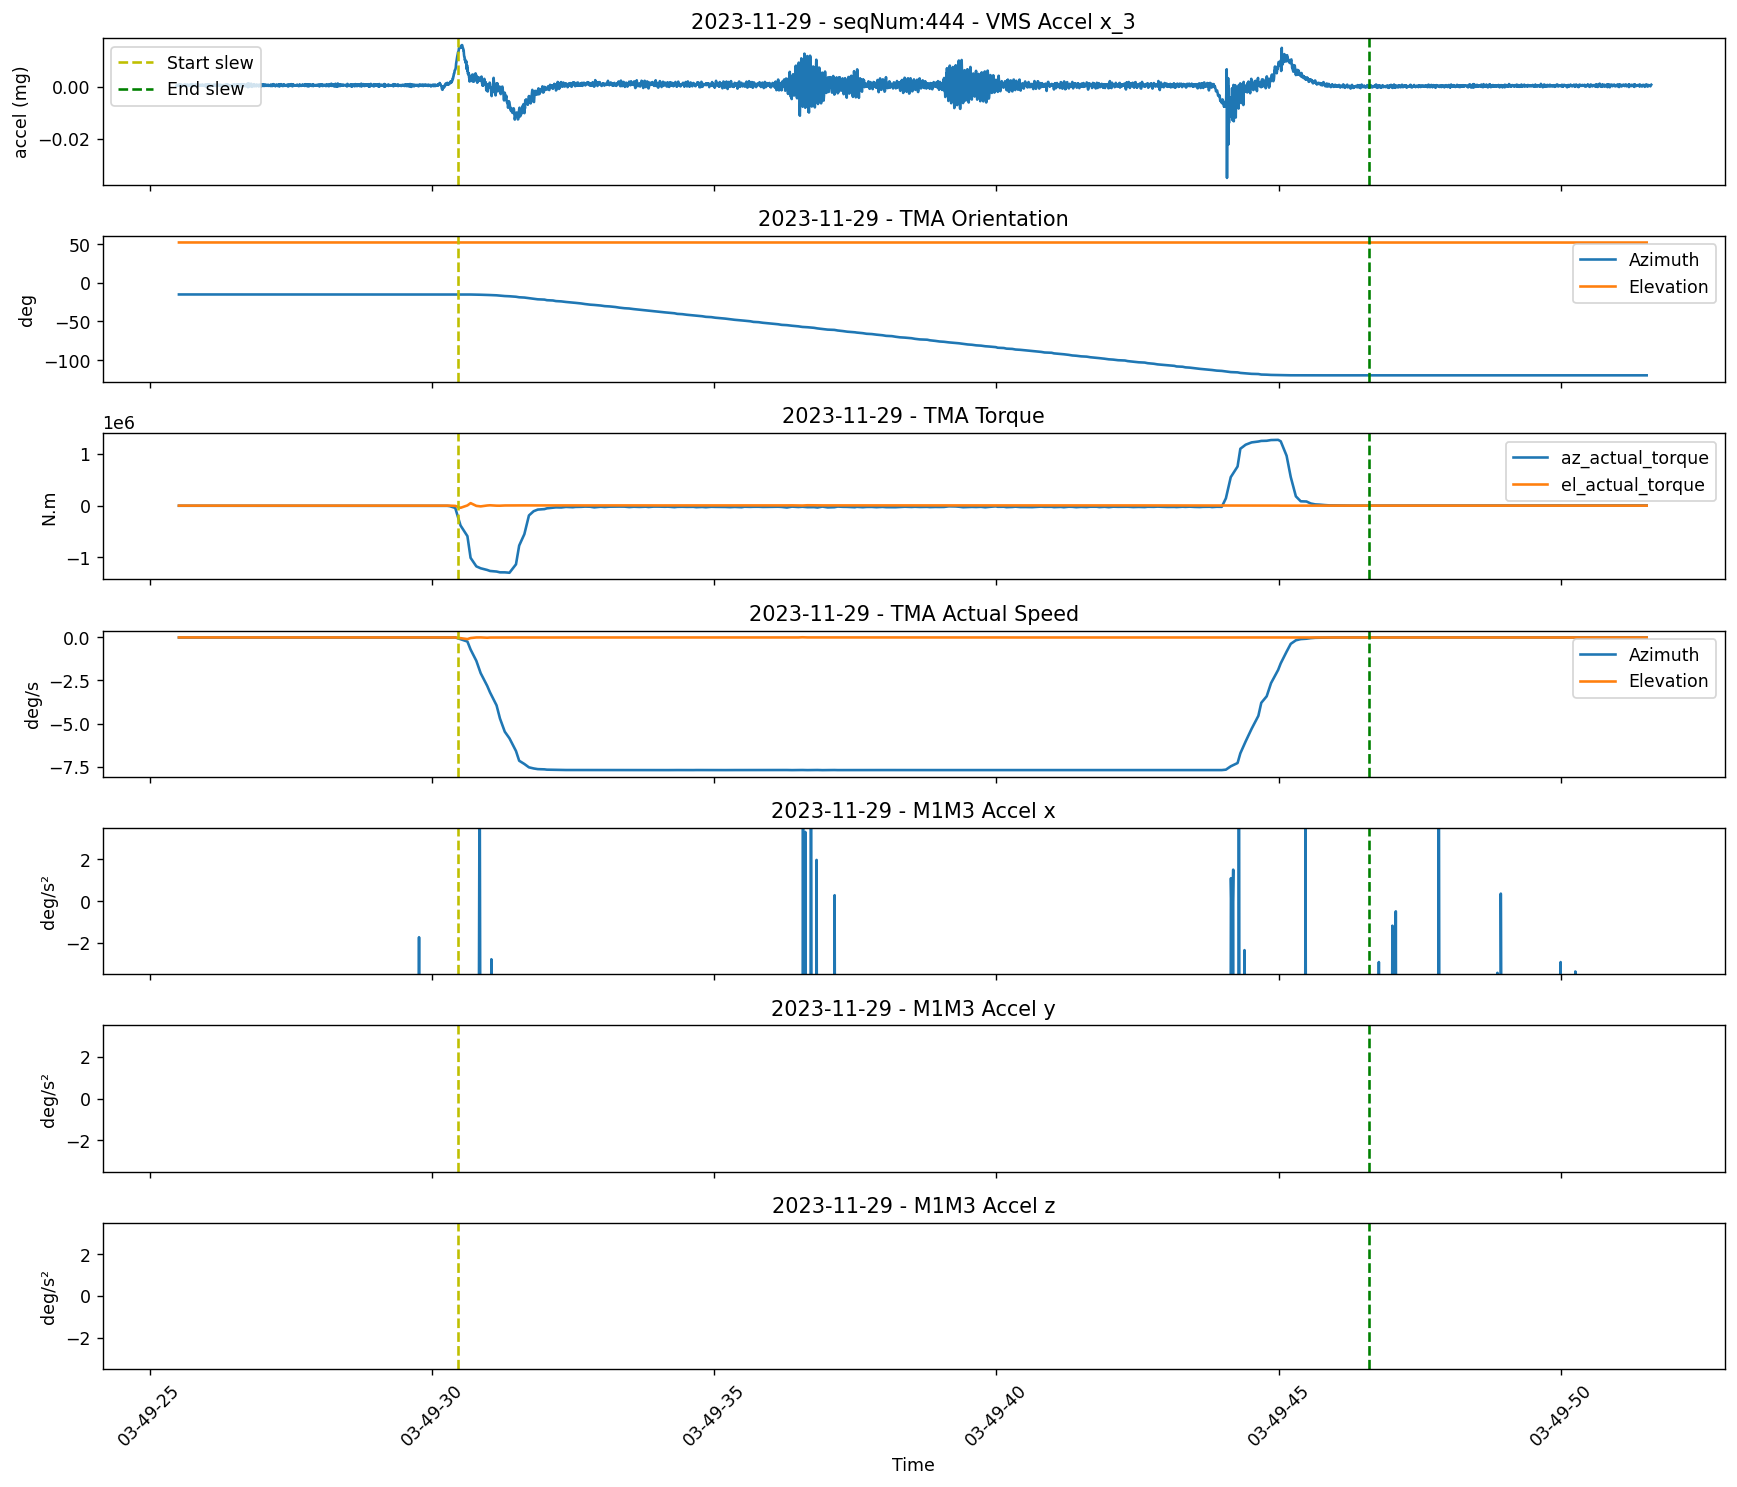

In [18]:
# Plot a few quantities to check that we have selected a good quality slew

fig, ax = plt.subplots(7, 1, sharex=True, dpi=125, figsize=(14, 12))
ax[0].plot(vms_m1m3_data["times"][sel], vms_m1m3_data["m1m3_x_3"][sel])
ax[0].set(
    ylabel="accel (mg)",
    title=f"{vms_date} - seqNum:{selected[0].seqNum} - VMS Accel x_3",
)
ax[1].plot(df_azi.index, df_azi["actualPosition"], label="Azimuth")
ax[1].plot(df_ele.index, df_ele["actualPosition"], label="Elevation")
ax[1].legend()
ax[1].set(ylabel="deg", title=f"{vms_date} - TMA Orientation")
ax[2].plot(df_azi.index, df_azi["actualTorque"], label="az_actual_torque")
ax[2].plot(df_ele.index, df_ele["actualTorque"], label="el_actual_torque")
ax[2].set(ylabel="N.m", title=f"{vms_date} - TMA Torque")
ax[2].legend()
ax[3].plot(df_azi.index, df_azi["actualVelocity"], label="Azimuth")
ax[3].plot(df_ele.index, df_ele["actualVelocity"], label="Elevation")
ax[3].set(ylabel="deg/s", title=f"{vms_date} - TMA Actual Speed")
ax[3].legend()
ax[4].plot(df_accel.index, df_accel["angularAccelerationX"])
ax[4].set(ylabel="deg/s²", title=f"{vms_date} - M1M3 Accel x")
ax[4].set_ylim([-3.5, 3.5])
ax[5].plot(df_accel.index, df_accel["angularAccelerationY"])
ax[5].set(ylabel="deg/s²", title=f"{vms_date} - M1M3 Accel y")
ax[5].set_ylim([-3.5, 3.5])
ax[6].plot(df_accel.index, df_accel["angularAccelerationZ"])
ax[6].set(ylabel="deg/s²", title=f"{vms_date} - M1M3 Accel z")
ax[6].set_ylim([-3.5, 3.5])
ax[len(ax) - 1].set_xlabel("Time")
for i in range(len(ax)):
    ax[i].xaxis.set_major_formatter(DateFormatter("%H-%M-%S"))
    plt.setp(ax[i].get_xticklabels(), rotation=45)
    for ct, ev in enumerate(selected):
        if i == 0 and ct == 0:
            ax[i].axvline(ev.begin.datetime64, color="y", ls="--", label="Start slew")
            ax[i].axvline(ev.end.datetime64, color="g", ls="--", label="End slew")
            ax[0].legend()
        else:
            ax[i].axvline(ev.begin.datetime64, color="y", ls="--")
            ax[i].axvline(ev.end.datetime64, color="g", ls="--")
    if i == 0:
        ax[0].legend(loc="upper left")
fig.tight_layout()
fig.savefig(f"{plot_dir}/overview-{vms_date}-{slew_select}.png")

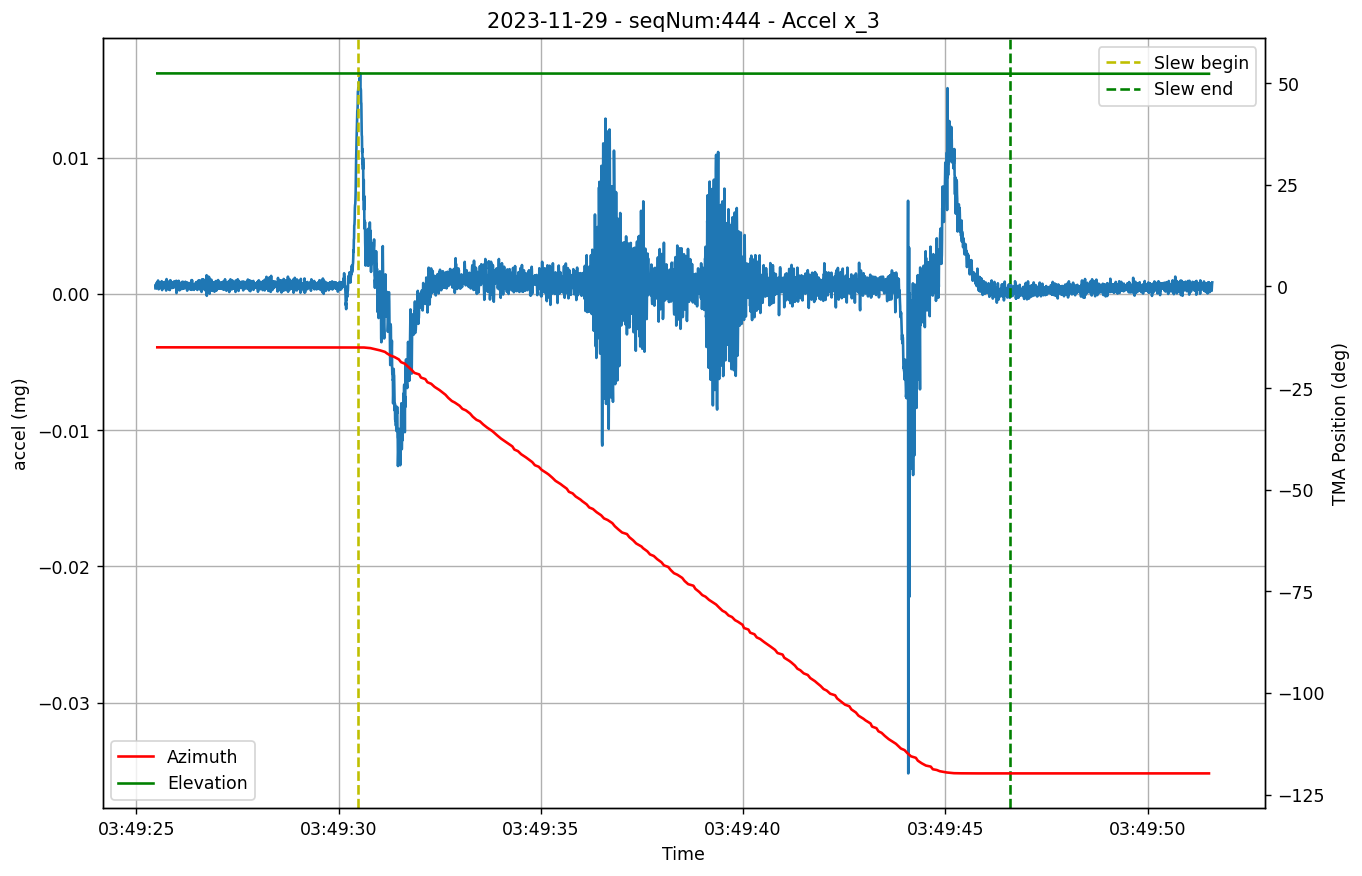

In [21]:
# Zoom in the acceleration measured by the VMS
fig, ax = plt.subplots(1, 1, dpi=125, figsize=(12, 8))
ax.plot(vms_m1m3_data["times"][sel], vms_m1m3_data["m1m3_x_3"][sel])
ax.set(
    ylabel="accel (mg)",
    xlabel="Time",
    title=f"{vms_date} - seqNum:{selected[0].seqNum} - Accel x_3",
)
ax2 = ax.twinx()
ax2.plot(df_azi.index, df_azi["actualPosition"], c="red", label="Azimuth")
ax2.plot(df_ele.index, df_ele["actualPosition"], c="green", label="Elevation")
ax2.set_ylabel("TMA Position (deg)")
ax2.legend()
for i, ev in enumerate(selected):
    ax.axvline(ev.begin.datetime64, color="y", ls="--", label="Slew begin")
    ax.axvline(ev.end.datetime64, color="g", ls="--", label="Slew end")
    if i == 0:
        ax.legend()
ax.grid(axis="both")
fig.savefig(f"{plot_dir}/VMS-zoom-{vms_date}-{slew_select}.png")

### Check whether HP forces are correlated with VMS data

In [23]:
df_hp = getEfdData(
    client, "lsst.sal.MTM1M3.hardpointActuatorData", begin=start_slew, end=end_slew
)

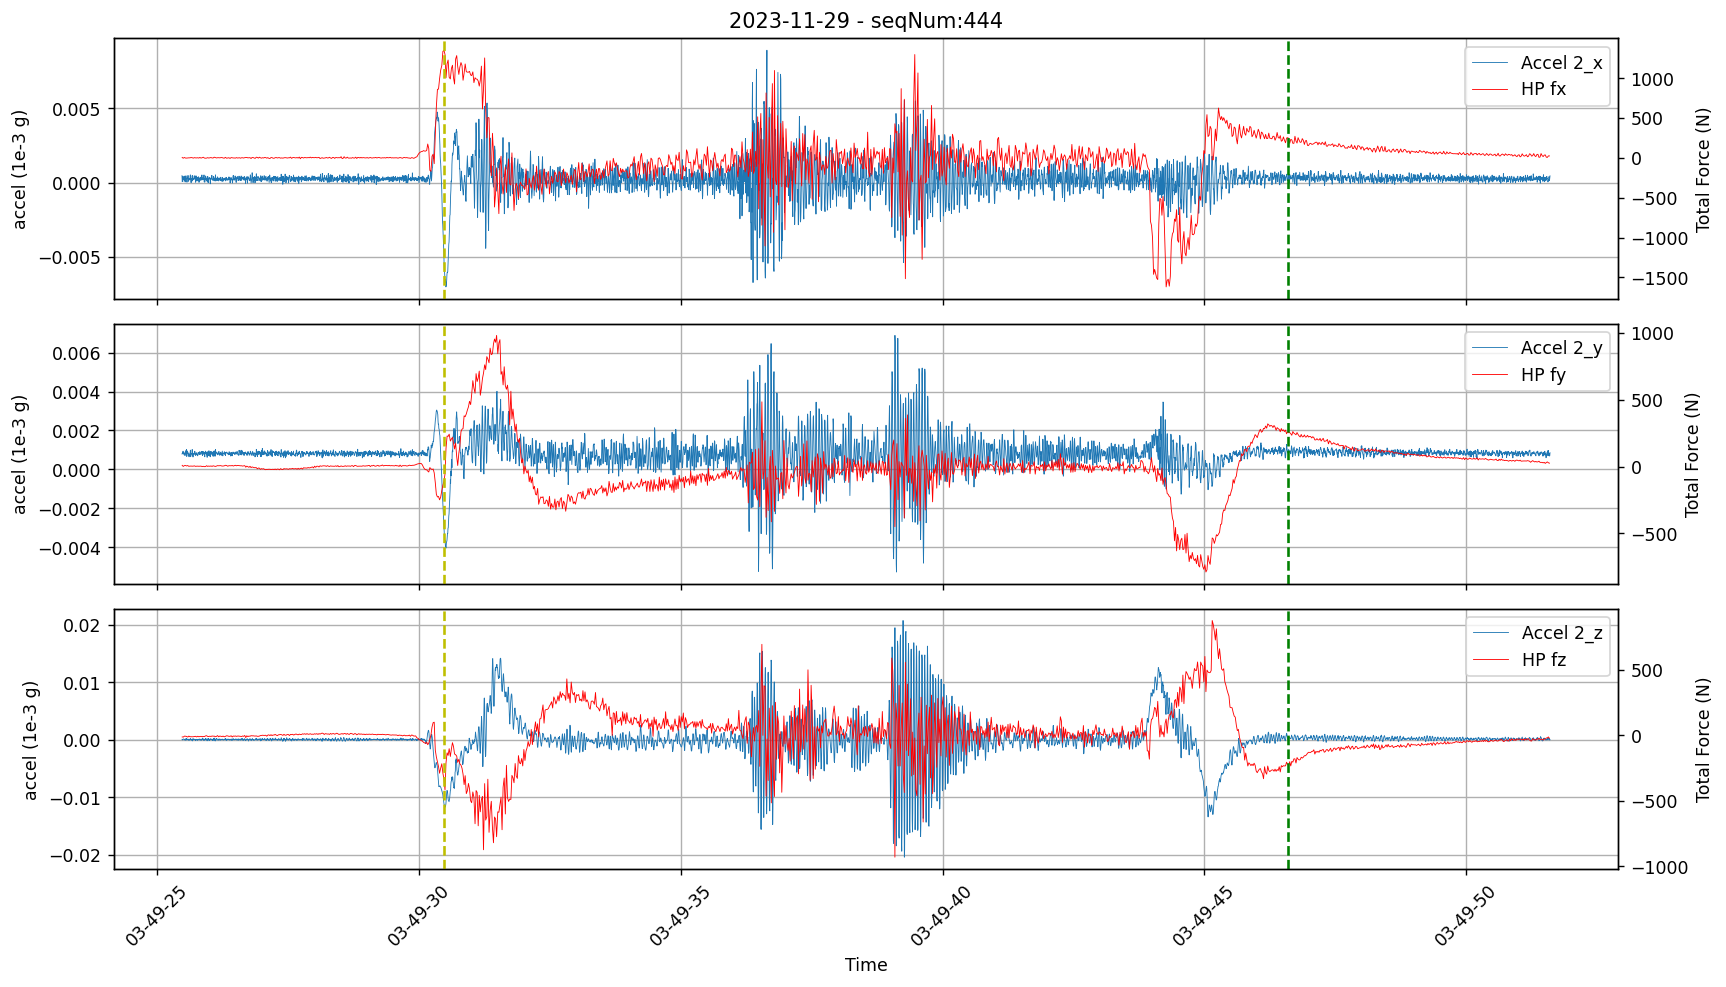

In [24]:
fig, ax = plt.subplots(3, 1, sharex=True, dpi=125, figsize=(14, 8))
bx = []
for i, axis in enumerate("xyz"):
    lns1 = ax[i].plot(
        vms_m1m3_data["times"][sel],
        vms_m1m3_data[f"m1m3_{axis}_2"][sel],
        lw=0.5,
        label=f"Accel 2_{axis}",
    )
    ax[i].set(ylabel="accel (1e-3 g)")
    bx.append(ax[i].twinx())
    lns2 = bx[i].plot(
        df_hp.index, df_hp[f"f{axis}"], c="red", lw=0.5, label=f"HP f{axis}"
    )
    bx[i].set_ylabel(f"Total Force (N)")
    ax[i].grid(axis="both")
    lns = lns1 + lns2
    labs = [l.get_label() for l in lns]
    ax[i].legend(lns, labs)
    for ct, ev in enumerate(selected):
        if i == 0 and ct == 0:
            bx[i].axvline(ev.begin.datetime64, color="y", ls="--", label="Start slew")
            bx[i].axvline(ev.end.datetime64, color="g", ls="--", label="End slew")
        else:
            bx[i].axvline(ev.begin.datetime64, color="y", ls="--")
            bx[i].axvline(ev.end.datetime64, color="g", ls="--")
ax[2].set(xlabel="Time")
ax[0].set(title=f"{vms_date} - seqNum:{selected[0].seqNum}")
ax[2].xaxis.set_major_formatter(DateFormatter("%H-%M-%S"))
plt.setp(ax[i].get_xticklabels(), rotation=45)
fig.tight_layout()
fig.savefig(f"{plot_dir}/VMS-HP-{vms_date}-{slew_select}.png")

In [25]:
def compare_mount_hardpoints(
    df_mtmount_ele,
    df_mtmount_azi,
    df_hp,
    begin,
    end,
):
    fig, axs = plt.subplots(1, 1, dpi=125, figsize=(15, 8))
    ax = axs  # [0]
    df_plot = df_hp["measuredForce0"][begin:end]
    ax.plot(df_plot, color="red", lw="0.5", label="HP 0")
    df_plot = df_hp["measuredForce1"][begin:end]
    ax.plot(df_plot, color="blue", lw="0.5", label="HP 1")
    df_plot = df_hp["measuredForce2"][begin:end]
    ax.plot(df_plot, color="black", lw="0.5", label="HP 2")
    df_plot = df_hp["measuredForce3"][begin:end]
    ax.plot(df_plot, color="green", lw="0.5", label="HP 3")
    df_plot = df_hp["measuredForce4"][begin:end]
    ax.plot(df_plot, color="orange", lw="0.5", label="HP 4")
    df_plot = df_hp["measuredForce5"][begin:end]
    ax.plot(df_plot, color="yellow", lw="0.5", label="HP 5")
    ax.set_ylabel("HP Force \n[N]")
    # ax.legend()
    ax2 = ax.twinx()
    # ax = axs[1]
    df_plot = df_mtmount_ele["actualPosition"][begin:end]
    ax2.plot(df_plot, color="green", lw="0.5", label="el")
    # ax.axvline(begin, lw="0.5", c="k", label="Slew start")
    # ax.axvline(end, lw="0.5", c="b", label="Slew stop")

    # ax = axs[2]
    df_plot = df_mtmount_azi["actualPosition"][begin:end]
    ax2.plot(df_plot, color="red", lw="0.5", label="az")
    ax2.set_ylabel("TMA El & Azimuth \nPosition\n[deg]")

    ax2.set_xlabel("UTC")
    ax2.legend()
    fig.autofmt_xdate()
    fig.subplots_adjust(hspace=1)
    fig.suptitle(t0)
    fig.tight_layout()

In [26]:
postPadding = 50.0

start_slew = Time(ev.begin, format="isot", scale="utc")  # start of slew
t0 = pd.to_datetime(start_slew.value, utc=True)  # astropy Time to Timestamp conversion
end_slew = Time(ev.end, format="isot", scale="utc")  # end of slew
t1 = pd.to_datetime(end_slew.value, utc=True)  # astropy Time to Timestamp conversion

# Get mount data
df_mtmount_ele = getEfdData(
    client,
    "lsst.sal.MTMount.elevation",
    begin=start_slew,
    end=end_slew,
)
df_mtmount_azi = getEfdData(
    client,
    "lsst.sal.MTMount.azimuth",
    begin=start_slew,
    end=end_slew,
)
df_hp = getEfdData(
    client, "lsst.sal.MTM1M3.hardpointActuatorData", begin=start_slew, end=end_slew
)

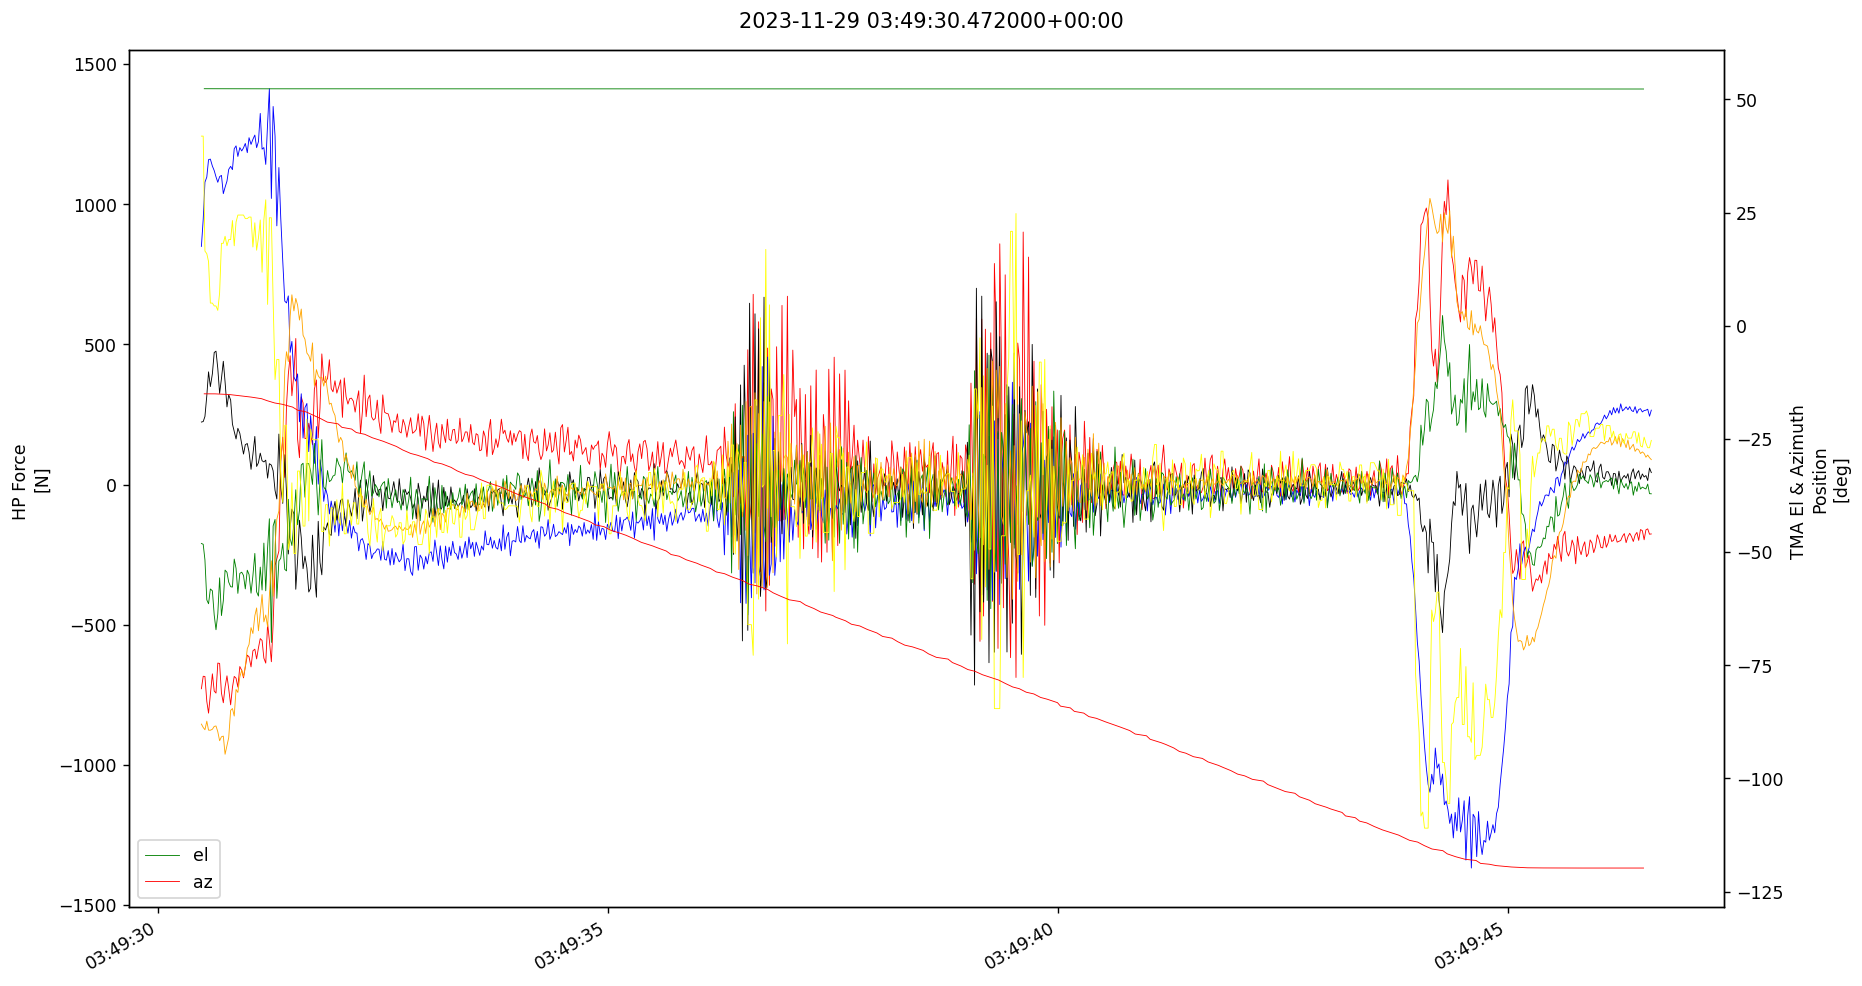

In [27]:
%matplotlib inline
compare_mount_hardpoints(
    df_mtmount_ele,
    df_mtmount_azi,
    df_hp,
    t0,
    t1,
)

In [28]:
def compare_mount_hardpoints_separate_plots(
    df_mtmount_ele,
    df_mtmount_azi,
    df_hp,
    begin,
    end,
):
    fig, axs = plt.subplots(3, 1, dpi=125, figsize=(15, 8))
    ax = axs[0]
    df_plot = df_hp["measuredForce0"][begin:end]
    ax.plot(df_plot, color="red", lw="0.5", label="HP 0")
    df_plot = df_hp["measuredForce1"][begin:end]
    ax.plot(df_plot, color="blue", lw="0.5", label="HP 1")
    df_plot = df_hp["measuredForce2"][begin:end]
    ax.plot(df_plot, color="black", lw="0.5", label="HP 2")
    df_plot = df_hp["measuredForce3"][begin:end]
    ax.plot(df_plot, color="green", lw="0.5", label="HP 3")
    df_plot = df_hp["measuredForce4"][begin:end]
    ax.plot(df_plot, color="orange", lw="0.5", label="HP 4")
    df_plot = df_hp["measuredForce5"][begin:end]
    ax.plot(df_plot, color="yellow", lw="0.5", label="HP 5")
    ax.set_ylabel("HP Force \n[N]")

    ax = axs[1]
    df_plot = df_mtmount_ele["actualPosition"][begin:end]
    ax.plot(df_plot, color="green", lw="0.5")
    ax.set_ylabel("TMA Elevation \nPosition\n[deg]")
    # ax.axvline(begin, lw="0.5", c="k", label="Slew start")
    # ax.axvline(end, lw="0.5", c="b", label="Slew stop")

    ax = axs[2]
    df_plot = df_mtmount_azi["actualPosition"][begin:end]
    ax.plot(df_plot, color="red", lw="0.5")
    ax.set_ylabel("TMA Azimuth \nPosition\n[deg]")

    ax.set_xlabel("UTC")
    fig.autofmt_xdate()
    fig.subplots_adjust(hspace=1)
    fig.suptitle(t0)
    fig.legend()
    fig.tight_layout()

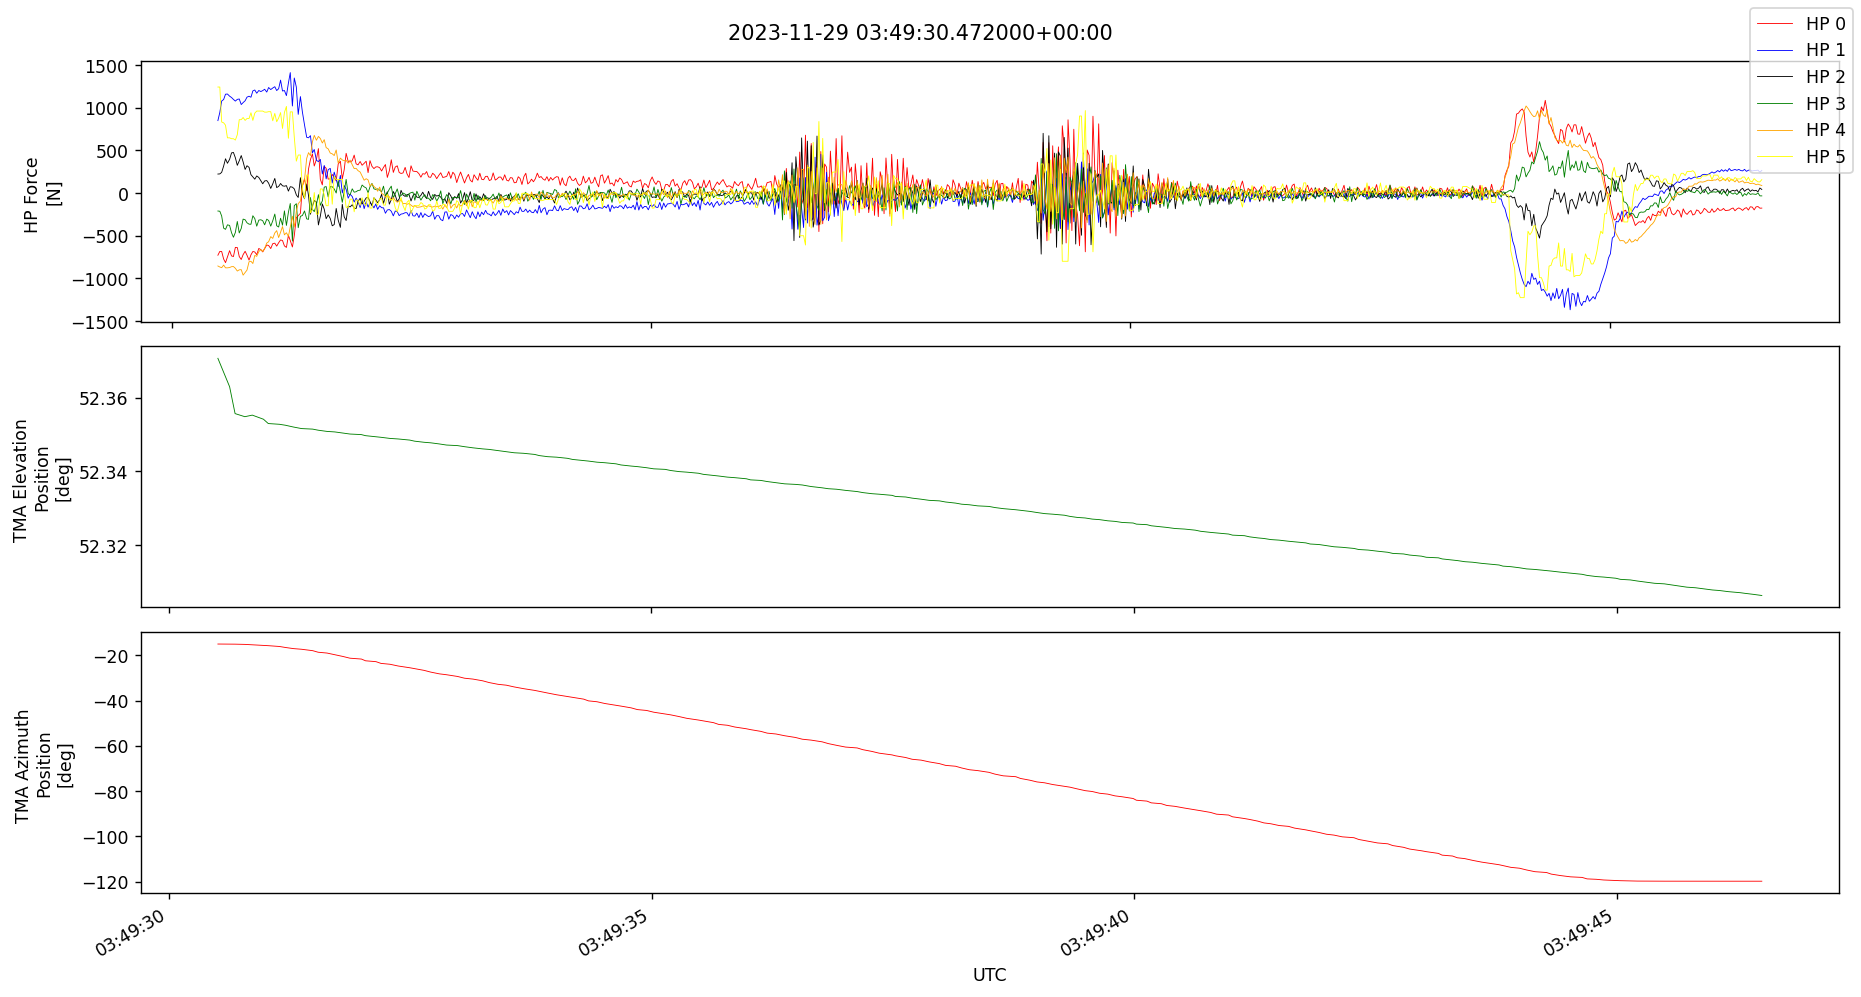

In [29]:
%matplotlib inline
compare_mount_hardpoints_separate_plots(
    df_mtmount_ele,
    df_mtmount_azi,
    df_hp,
    t0,
    t1,
)